In [1]:


!pip install wget
import wget
url = 'https://lass.cs.umass.edu/smarttraces/2017/HomeC-electrical.tar.gz'
filename = wget.download(url)
print(filename)

--2023-05-08 20:00:37--  https://lass.cs.umass.edu/smarttraces/2017/HomeC-electrical.tar.gz
Resolving lass.cs.umass.edu (lass.cs.umass.edu)... 128.119.245.5
Connecting to lass.cs.umass.edu (lass.cs.umass.edu)|128.119.245.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29233308 (28M) [application/x-gzip]
Saving to: ‘HomeC-electrical.tar.gz’

HomeC-electrical.ta 100%[===================>]  27.88M  32.9MB/s    in 0.8s    

2023-05-08 20:00:38 (32.9 MB/s) - ‘HomeC-electrical.tar.gz’ saved [29233308/29233308]



In [2]:
# unzip
!tar -xvf HomeC-electrical.tar.gz

HomeC/
HomeC/2016/
HomeC/2016/SUMMARY_HomeC-meter2.txt
HomeC/2016/HomeC-meter2_2016.csv
HomeC/2016/SUMMARY_HomeC-meter1.txt
HomeC/2016/HomeC-meter1_2016.csv
HomeC/2014/
HomeC/2014/SUMMARY_HomeC-meter2.txt
HomeC/2014/HomeC-meter1_2014.csv
HomeC/2014/SUMMARY_HomeC-meter1.txt
HomeC/2014/HomeC-meter2_2014.csv
HomeC/2015/
HomeC/2015/SUMMARY_HomeC-meter2.txt
HomeC/2015/HomeC-meter1_2015.csv
HomeC/2015/SUMMARY_HomeC-meter1.txt
HomeC/2015/HomeC-meter2_2015.csv


In [3]:

import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:

data_path = 'HomeC/'

In [6]:

data_1 = pd.read_csv(data_path + '2014/HomeC-meter1_2014.csv')
data_2 = pd.read_csv(data_path + '2014/HomeC-meter2_2014.csv')


In [7]:
data_1.columns

Index(['Date & Time', 'use [kW]', 'gen [kW]', 'House overall [kW]',
       'Dishwasher [kW]', 'Furnace 1 [kW]', 'Furnace 2 [kW]',
       'Home office [kW]', 'Fridge [kW]', 'Wine cellar [kW]',
       'Garage door [kW]', 'Kitchen 12 [kW]', 'Kitchen 14 [kW]',
       'Kitchen 38 [kW]', 'Barn [kW]', 'Well [kW]', 'Microwave [kW]',
       'Living room [kW]', 'Solar [kW]'],
      dtype='object')

In [8]:
data_2.columns

Index(['Date & Time', 'use [kW]', 'gen [kW]', 'LivingRoomOutlets [kW]',
       'Barn [kW]', 'Well [kW]', 'Microwave [kW]', 'WasherDrier [kW]',
       'Solar [kW]'],
      dtype='object')

In [9]:
data_3 = pd.read_csv(data_path + '2015/HomeC-meter1_2015.csv')
data_4 = pd.read_csv(data_path + '2015/HomeC-meter2_2015.csv')

In [10]:
data_3.columns

Index(['Date & Time', 'use [kW]', 'gen [kW]', 'House overall [kW]',
       'Dishwasher [kW]', 'Furnace 1 [kW]', 'Furnace 2 [kW]',
       'Home office [kW]', 'Fridge [kW]', 'Wine cellar [kW]',
       'Garage door [kW]', 'Kitchen 12 [kW]', 'Kitchen 14 [kW]',
       'Kitchen 38 [kW]', 'Barn [kW]', 'Well [kW]', 'Microwave [kW]',
       'Living room [kW]', 'Solar [kW]'],
      dtype='object')

In [11]:
data_4.columns

Index(['Date & Time', 'use [kW]', 'gen [kW]', 'LivingRoomOutlets [kW]',
       'Barn [kW]', 'Well [kW]', 'Microwave [kW]', 'WasherDrier [kW]',
       'Solar [kW]'],
      dtype='object')

In [12]:


# load data
def load_data(path):
    data = []
    for year in range(2014, 2017):
        for meter in range(1, 3):
            file_path = path + str(year) + '/HomeC-meter1_' + str(year) + '.csv'
            data.append(pd.read_csv(file_path))
    return data

data = load_data(data_path)


In [13]:

# convert data to pandas dataframe
def convert_to_df(data):
    df = pd.DataFrame()
    for i in range(len(data)):
        df = df.append(data[i])
    return df

dataset = convert_to_df(data)
dataset.head()

,Date & Time,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],Garage door [kW],Kitchen 12 [kW],Kitchen 14 [kW],Kitchen 38 [kW],Barn [kW],Well [kW],Microwave [kW],Living room [kW],Solar [kW]
0,2014-01-01 00:00:00,2.108589,0.004111,2.108589,0.000023,0.100391,0.063347,0.040204,0.136891,0.004294,0.009579,0.000168,0.000023,0.000003,0.087443,0.000116,0.003593,0.102349,0.004111
1,2014-01-01 00:30:00,1.828066,0.004040,1.828066,0.000059,0.170241,0.063181,0.039184,0.146551,0.004210,0.009384,0.000261,0.000126,0.000002,0.141680,0.079844,0.039922,0.038129,0.004040
2,2014-01-01 01:00:00,0.960618,0.004423,0.960618,0.000062,0.191079,0.129996,0.039070,0.063167,0.004314,0.009709,0.000547,0.000039,0.000004,0.035265,0.000556,0.003914,0.007687,0.004423
3,2014-01-01 01:30:00,0.956158,0.004581,0.956158,0.000056,0.227550,0.274561,0.039026,0.005300,0.004406,0.009844,0.000677,0.000034,0.000007,0.035409,0.000016,0.003287,0.004327,0.004581
4,2014-01-01 02:00:00,1.111968,0.004586,1.111968,0.000056,0.272573,0.376884,0.038959,0.005165,0.004447,0.009871,0.000669,0.000007,0.000008,0.035453,0.000017,0.003280,0.001753,0.004586


In [14]:

# explore data
dataset.describe()

,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],Garage door [kW],Kitchen 12 [kW],Kitchen 14 [kW],Kitchen 38 [kW],Barn [kW],Well [kW],Microwave [kW],Living room [kW],Solar [kW]
count,1.122388e+06,1.122388e+06,1.122388e+06,1.122388e+06,1.122388e+06,1.122388e+06,1.122388e+06,1.122388e+06,1.122388e+06,1.122388e+06,1.122388e+06,1.122388e+06,1.122388e+06,1.122388e+06,1.122388e+06,1.122388e+06,1.122388e+06,1.122388e+06
mean,8.586093e-01,7.434275e-02,8.586093e-01,3.184114e-02,1.006452e-01,1.380187e-01,8.098821e-02,6.304383e-02,4.041510e-02,1.406003e-02,2.646124e-03,7.263566e-03,9.125672e-06,6.018542e-02,1.571743e-02,1.093606e-02,3.562499e-02,7.434275e-02
std,1.027684e+00,1.276012e-01,1.027684e+00,1.902896e-01,1.680745e-01,1.773840e-01,1.035455e-01,7.505205e-02,5.675952e-02,1.404396e-02,2.147780e-02,7.570843e-02,9.793845e-06,2.037356e-01,1.348729e-01,9.710667e-02,9.573338e-02,1.276012e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.666700e-05,6.666700e-05,8.333300e-05,1.666700e-05,0.000000e+00,1.666700e-05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.729667e-01,3.350000e-03,3.729667e-01,0.000000e+00,2.023333e-02,6.428333e-02,4.025000e-02,5.083333e-03,7.050000e-03,1.270000e-02,5.000000e-04,1.666700e-05,0.000000e+00,2.986667e-02,9.833330e-04,3.397222e-03,1.466667e-03,3.350000e-03
50%,5.713833e-01,4.283333e-03,5.713833e-01,1.666700e-05,2.061667e-02,6.655000e-02,4.216667e-02,5.500000e-03,8.033333e-03,1.291667e-02,6.666670e-04,6.388900e-05,5.556000e-06,3.140000e-02,1.000000e-03,4.000000e-03,1.600000e-03,4.283333e-03
75%,9.835833e-01,7.785000e-02,9.835833e-01,2.333330e-04,7.005000e-02,8.088333e-02,6.776667e-02,1.250000e-01,4.265000e-02,1.310000e-02,7.500000e-04,1.666670e-04,1.666700e-05,3.315000e-02,1.016667e-03,4.083333e-03,1.750000e-03,7.785000e-02
max,1.471457e+01,1.043312e+00,1.471457e+01,1.401767e+00,1.934083e+00,7.949333e-01,9.717500e-01,8.512667e-01,1.273933e+00,1.110674e+00,1.166583e+00,2.262583e+00,1.833330e-04,7.027900e+00,1.633017e+00,1.929800e+00,4.652167e-01,1.043312e+00


In [15]:

dataset.shape   

(1122388, 19)

In [16]:

# info
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1122388 entries, 0 to 503909
Data columns (total 19 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   Date & Time         1122388 non-null  object 
 1   use [kW]            1122388 non-null  float64
 2   gen [kW]            1122388 non-null  float64
 3   House overall [kW]  1122388 non-null  float64
 4   Dishwasher [kW]     1122388 non-null  float64
 5   Furnace 1 [kW]      1122388 non-null  float64
 6   Furnace 2 [kW]      1122388 non-null  float64
 7   Home office [kW]    1122388 non-null  float64
 8   Fridge [kW]         1122388 non-null  float64
 9   Wine cellar [kW]    1122388 non-null  float64
 10  Garage door [kW]    1122388 non-null  float64
 11  Kitchen 12 [kW]     1122388 non-null  float64
 12  Kitchen 14 [kW]     1122388 non-null  float64
 13  Kitchen 38 [kW]     1122388 non-null  float64
 14  Barn [kW]           1122388 non-null  float64
 15  Well [kW]       

In [17]:

# data types
dataset.dtypes

Date & Time            object
use [kW]              float64
gen [kW]              float64
House overall [kW]    float64
Dishwasher [kW]       float64
Furnace 1 [kW]        float64
Furnace 2 [kW]        float64
Home office [kW]      float64
Fridge [kW]           float64
Wine cellar [kW]      float64
Garage door [kW]      float64
Kitchen 12 [kW]       float64
Kitchen 14 [kW]       float64
Kitchen 38 [kW]       float64
Barn [kW]             float64
Well [kW]             float64
Microwave [kW]        float64
Living room [kW]      float64
Solar [kW]            float64
dtype: object

In [18]:

# check null values
dataset.isnull().sum()

Date & Time           0
use [kW]              0
gen [kW]              0
House overall [kW]    0
Dishwasher [kW]       0
Furnace 1 [kW]        0
Furnace 2 [kW]        0
Home office [kW]      0
Fridge [kW]           0
Wine cellar [kW]      0
Garage door [kW]      0
Kitchen 12 [kW]       0
Kitchen 14 [kW]       0
Kitchen 38 [kW]       0
Barn [kW]             0
Well [kW]             0
Microwave [kW]        0
Living room [kW]      0
Solar [kW]            0
dtype: int64

In [19]:

# check columns
dataset.columns

Index(['Date & Time', 'use [kW]', 'gen [kW]', 'House overall [kW]',
       'Dishwasher [kW]', 'Furnace 1 [kW]', 'Furnace 2 [kW]',
       'Home office [kW]', 'Fridge [kW]', 'Wine cellar [kW]',
       'Garage door [kW]', 'Kitchen 12 [kW]', 'Kitchen 14 [kW]',
       'Kitchen 38 [kW]', 'Barn [kW]', 'Well [kW]', 'Microwave [kW]',
       'Living room [kW]', 'Solar [kW]'],
      dtype='object')

In [20]:
# convert date time to datetime format
dataset['Date & Time'] = pd.to_datetime(dataset['Date & Time'])

In [21]:


# data visualization
import matplotlib.pyplot as plt
import seaborn as sns


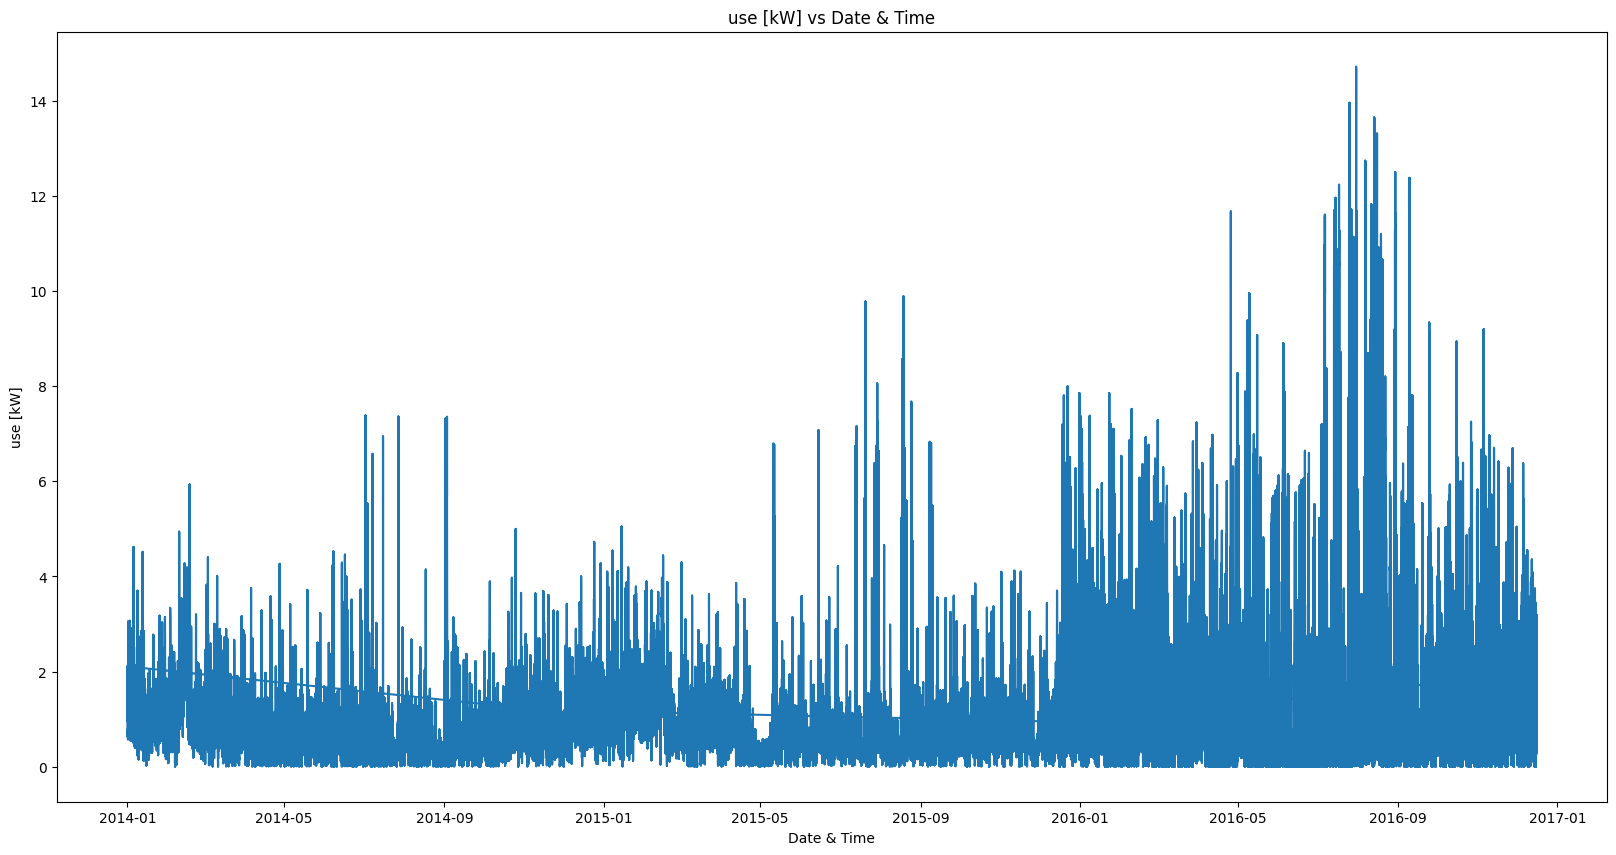

In [22]:

# plot data
plt.figure(figsize=(20, 10))
plt.plot(dataset['Date & Time'], dataset['use [kW]'])
plt.xlabel('Date & Time')
plt.ylabel('use [kW]')
plt.title('use [kW] vs Date & Time')
plt.show()

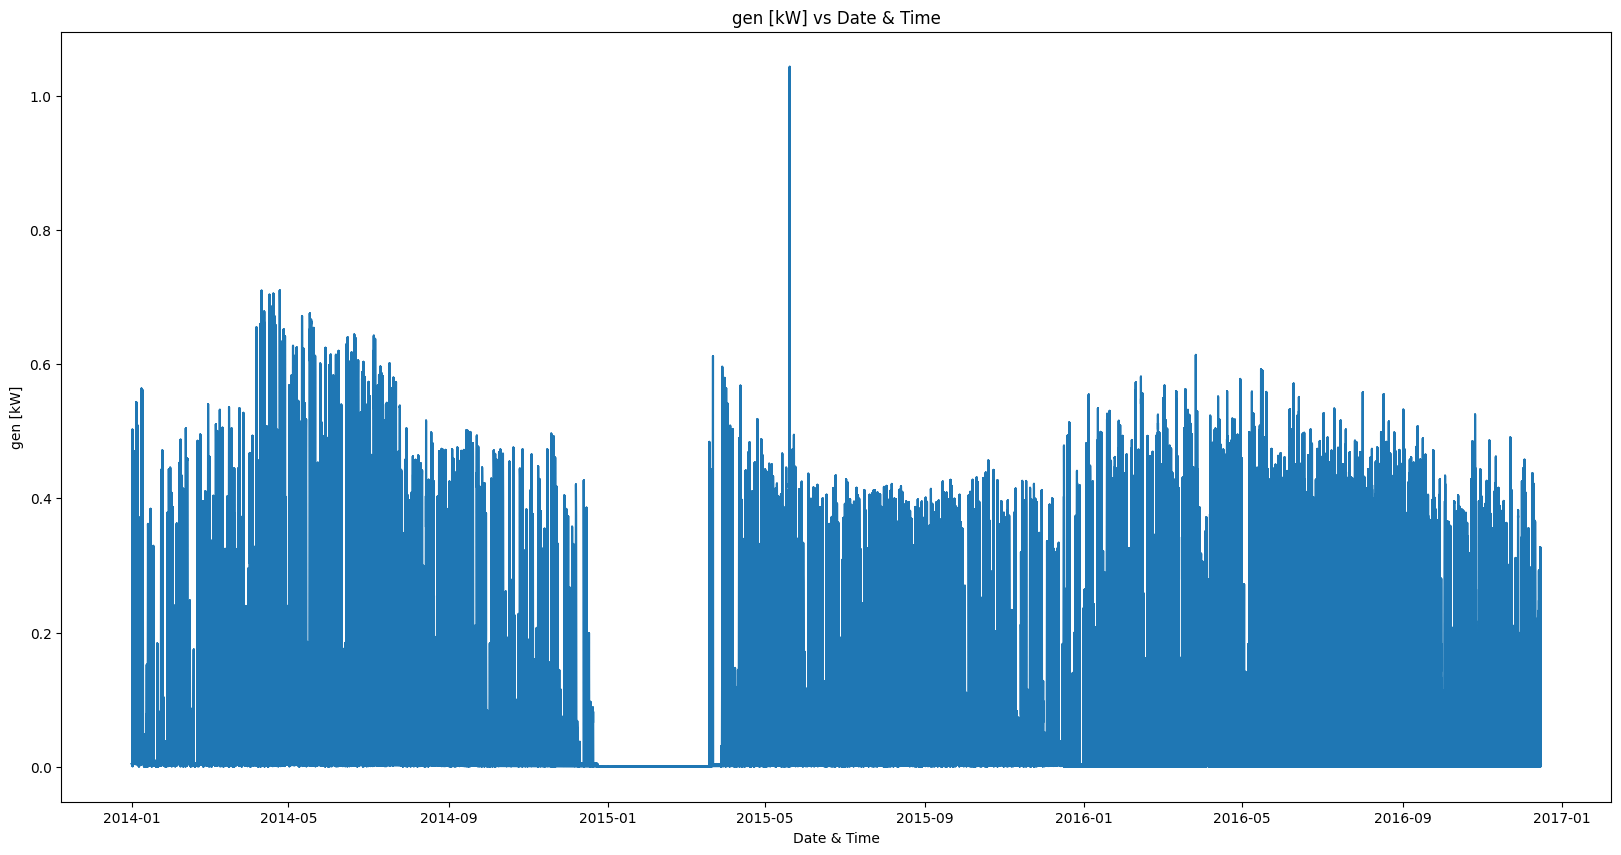

In [23]:

# plot data
plt.figure(figsize=(20, 10))
plt.plot(dataset['Date & Time'], dataset['gen [kW]'])
plt.xlabel('Date & Time')
plt.ylabel('gen [kW]')
plt.title('gen [kW] vs Date & Time')
plt.show()


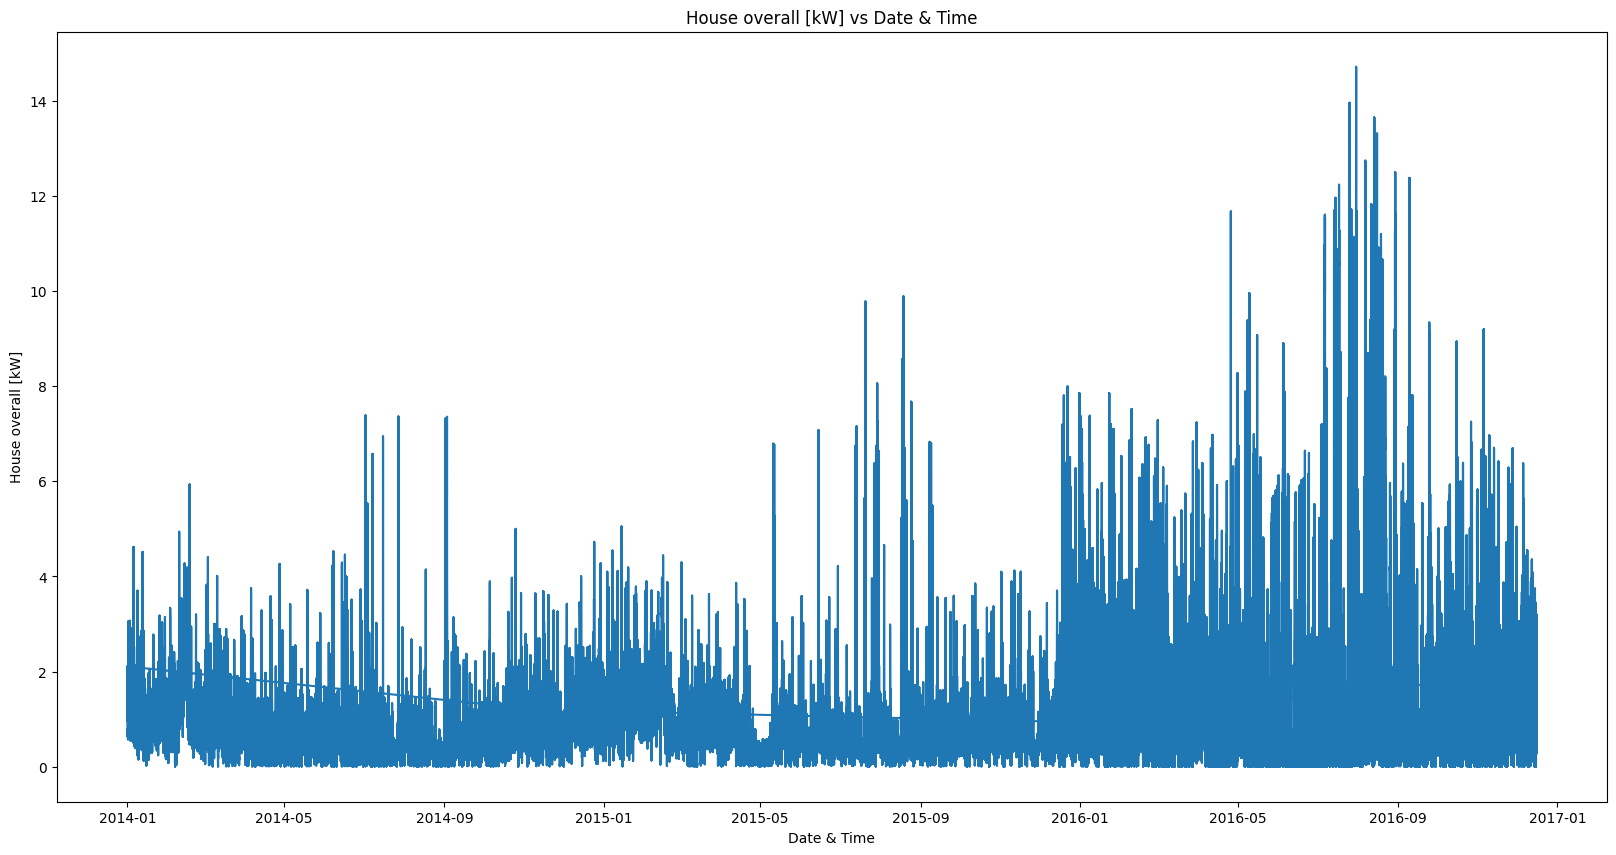

In [24]:

# plot data
plt.figure(figsize=(20, 10))
plt.plot(dataset['Date & Time'], dataset['House overall [kW]'])
plt.xlabel('Date & Time')
plt.ylabel('House overall [kW]')
plt.title('House overall [kW] vs Date & Time')
plt.show()


In [25]:
# 2. Data Preprocessing

# feature engineering

# create new features
dataset['year'] = dataset['Date & Time'].dt.year
dataset['month'] = dataset['Date & Time'].dt.month
dataset['day'] = dataset['Date & Time'].dt.day
dataset['hour'] = dataset['Date & Time'].dt.hour

In [26]:
dataset.head()

,Date & Time,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],...,Kitchen 38 [kW],Barn [kW],Well [kW],Microwave [kW],Living room [kW],Solar [kW],year,month,day,hour
0,2014-01-01 00:00:00,2.108589,0.004111,2.108589,0.000023,0.100391,0.063347,0.040204,0.136891,0.004294,...,0.000003,0.087443,0.000116,0.003593,0.102349,0.004111,2014,1,1,0
1,2014-01-01 00:30:00,1.828066,0.004040,1.828066,0.000059,0.170241,0.063181,0.039184,0.146551,0.004210,...,0.000002,0.141680,0.079844,0.039922,0.038129,0.004040,2014,1,1,0
2,2014-01-01 01:00:00,0.960618,0.004423,0.960618,0.000062,0.191079,0.129996,0.039070,0.063167,0.004314,...,0.000004,0.035265,0.000556,0.003914,0.007687,0.004423,2014,1,1,1
3,2014-01-01 01:30:00,0.956158,0.004581,0.956158,0.000056,0.227550,0.274561,0.039026,0.005300,0.004406,...,0.000007,0.035409,0.000016,0.003287,0.004327,0.004581,2014,1,1,1
4,2014-01-01 02:00:00,1.111968,0.004586,1.111968,0.000056,0.272573,0.376884,0.038959,0.005165,0.004447,...,0.000008,0.035453,0.000017,0.003280,0.001753,0.004586,2014,1,1,2


In [27]:

dataset.columns

Index(['Date & Time', 'use [kW]', 'gen [kW]', 'House overall [kW]',
       'Dishwasher [kW]', 'Furnace 1 [kW]', 'Furnace 2 [kW]',
       'Home office [kW]', 'Fridge [kW]', 'Wine cellar [kW]',
       'Garage door [kW]', 'Kitchen 12 [kW]', 'Kitchen 14 [kW]',
       'Kitchen 38 [kW]', 'Barn [kW]', 'Well [kW]', 'Microwave [kW]',
       'Living room [kW]', 'Solar [kW]', 'year', 'month', 'day', 'hour'],
      dtype='object')

In [28]:


# check null values
dataset.isnull().sum()

Date & Time           0
use [kW]              0
gen [kW]              0
House overall [kW]    0
Dishwasher [kW]       0
Furnace 1 [kW]        0
Furnace 2 [kW]        0
Home office [kW]      0
Fridge [kW]           0
Wine cellar [kW]      0
Garage door [kW]      0
Kitchen 12 [kW]       0
Kitchen 14 [kW]       0
Kitchen 38 [kW]       0
Barn [kW]             0
Well [kW]             0
Microwave [kW]        0
Living room [kW]      0
Solar [kW]            0
year                  0
month                 0
day                   0
hour                  0
dtype: int64

In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

In [30]:

# train test split
train, test = train_test_split(dataset, test_size=0.2, random_state=0)

train.shape, test.shape


((897910, 23), (224478, 23))

In [31]:

# create model
model = Sequential()
model.add(LSTM(50, input_shape=(1, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


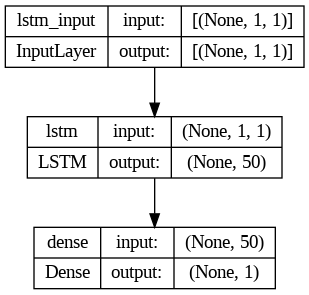

In [34]:
from keras.utils import plot_model
plot_model(model, to_file='lstm_model.png', show_shapes=True, show_layer_names=True)

In [32]:
# reshape data
X_train = np.reshape(train['House overall [kW]'].values, (train.shape[0], 1, 1))
X_test = np.reshape(test['House overall [kW]'].values, (test.shape[0], 1, 1))


In [33]:

# fit model
model.fit(X_train, train['House overall [kW]'].values, epochs=10, batch_size=1, verbose=1, steps_per_epoch=50000)

Epoch 1/10
 2251/50000 [>.............................] - ETA: 2:07 - loss: 0.1966

KeyboardInterrupt: ignored

In [ ]:

# make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [ ]:
y_train = train['House overall [kW]'].values
y_test = test['House overall [kW]'].values

# calculate rmse
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))

In [ ]:

print('Train RMSE: ', train_rmse)
print('Test RMSE: ', test_rmse)


In [ ]:
# calculate mae
train_mae = mean_absolute_error(y_train, train_predict)
test_mae = mean_absolute_error(y_test, test_predict)

print('Train MAE: ', train_mae)
print('Test MAE: ', test_mae)


In [ ]:
from sklearn.metrics import r2_score

# calculate r2 score
train_r2 = r2_score(y_train, train_predict)
test_r2 = r2_score(y_test, test_predict)

print('Train R2: ', train_r2)
print('Test R2: ', test_r2)

In [ ]:
# plot data
plt.figure(figsize=(20, 10))
plt.plot(dataset['Date & Time'], dataset['House overall [kW]'], label='Actual')
plt.plot(dataset['Date & Time'], dataset['House overall [kW]'], label='Predicted')
plt.xlabel('Date & Time')
plt.ylabel('House overall [kW]')
plt.title('House overall [kW] vs Date & Time')
plt.legend()
plt.show()

In [ ]:

# save model
model.save('model.h5')
